## Colab用 環境準備

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Mecabインストール
!sudo apt install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file swig
#形態素解析器辞書としてmecab-ipadic-NEologd
!sudo apt install git make curl xz-utils file

Reading package lists... Done
Building dependency tree       
Reading state information... Done
make is already the newest version (4.1-9.1ubuntu1).
make set to manually installed.
xz-utils is already the newest version (5.2.2-1.3).
xz-utils set to manually installed.
curl is already the newest version (7.58.0-2ubuntu3.10).
git is already the newest version (1:2.17.1-1ubuntu0.7).
The following additional packages will be installed:
  libmagic-mgc libmagic1 libmecab2 mecab-ipadic mecab-jumandic
  mecab-jumandic-utf8 mecab-utils swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  file libmagic-mgc libmagic1 libmecab-dev libmecab2 mecab mecab-ipadic
  mecab-ipadic-utf8 mecab-jumandic mecab-jumandic-utf8 mecab-utils swig
  swig3.0
0 upgraded, 13 newly installed, 0 to remove and 21 not upgraded.
Need to get 30.4 MB of archives.
After this operation, 288 MB of additional disk space will be used.
Get:1 http://archiv

In [4]:
cd /tmp

/tmp


In [5]:
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [6]:
cd mecab-ipadic-neologd

/tmp/mecab-ipadic-neologd


In [7]:
!./bin/install-mecab-ipadic-neologd -n

[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd] : Check the existance of libraries
[install-mecab-ipadic-NEologd] :     find => ok
[install-mecab-ipadic-NEologd] :     sort => ok
[install-mecab-ipadic-NEologd] :     head => ok
[install-mecab-ipadic-NEologd] :     cut => ok
[install-mecab-ipadic-NEologd] :     egrep => ok
[install-mecab-ipadic-NEologd] :     mecab => ok
[install-mecab-ipadic-NEologd] :     mecab-config => ok
[install-mecab-ipadic-NEologd] :     make => ok
[install-mecab-ipadic-NEologd] :     curl => ok
[install-mecab-ipadic-NEologd] :     sed => ok
[install-mecab-ipadic-NEologd] :     cat => ok
[install-mecab-ipadic-NEologd] :     diff => ok
[install-mecab-ipadic-NEologd] :     tar => ok
[install-mecab-ipadic-NEologd] :     unxz => ok
[install-mecab-ipadic-NEologd] :     xargs => ok
[install-mecab-ipadic-NEologd] :     grep => ok
[install-mecab-ipadic-NEologd] :     iconv => ok
[install-mecab-ipadic-NEologd] :     patch => ok
[install-mecab-ipadi

In [8]:
# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

In [9]:
!pip install mojimoji
!pip install mecab-python3

     |████████████████████████████████| 133kB 9.1MB/s 
     |████████████████████████████████| 3.5MB 8.3MB/s 


In [1]:
import os
import re
import time
from contextlib import contextmanager
from operator import itemgetter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_log_error, r2_score

from google.cloud import storage

import re, MeCab
from glob import glob
import mojimoji
import warnings
warnings.simplefilter("ignore")

from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.utils import np_utils
from multiprocessing.pool import ThreadPool

#環境変数,
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../auth/My First Project.json"
bucket_name = "pj_horidasimono"
prefix="dataset/train/ElectricalAppliance"
#最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 200)
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 200)


In [2]:
import os
import urllib.request

def download_stopwords(path):
    url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    if os.path.exists(path):
        print('File already exists.')
    else:
        print('Downloading...')
        # Download the file from `url` and save it locally under `file_name`:
        urllib.request.urlretrieve(url, path)

def create_stopwords(file_path):
    stop_words = []
    for w in open(path, "r"):
        w = w.replace('\n','')
        if len(w) > 0:
          stop_words.append(w)
    return stop_words    

path = "stop_words.txt"
download_stopwords(path)
stop_words = create_stopwords(path)

File already exists.


In [3]:
def road_data_from_gcs(bucket_name, prefix):
    client = storage.Client()
    blobs = client.list_blobs(bucket_name, prefix=prefix)
    df = pd.DataFrame()
    for blob in blobs:
        bucket = client.get_bucket(bucket_name)
        r = storage.Blob(blob.name, bucket)
        content = r.download_as_string()
        df = df.append(pd.read_json(content))
        print(f"read file {blob.name}...")

    df = df.drop_duplicates(subset="url")
    df = df.reset_index(drop=True)
    return df

In [4]:
tagger = MeCab.Tagger("-Owakati -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd")
def make_wakati(sentence):
    # MeCabで分かち書き
    sentence = sentence.lower()
    sentence = tagger.parse(sentence)
    sentence = mojimoji.zen_to_han(sentence)
    # 半角全角英数字除去
    #sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—♬◉ᴗ͈ˬ●▲★☆⭐️⭕⚡⚠①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮♡⭐︎〇◎◆◼♦▼◇△□(：〜～＋=)／*&^%$#@!~`)♪ᴖ◡ᴖｰ{}［］↑↓←→➡⇩™･⊡…\[\]\"\'\”\’:;<>?＜＞〔〕\r＼−〈〉？、､。｡・,\./『』【】｢｣「」→←○《》≪≫\n\u3000⭕]+', "", sentence)
    # 絵文字除去
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           "]+", flags=re.UNICODE)
    sentence = emoji_pattern.sub(r'', sentence)
    # スペースで区切って形態素の配列へ
    #wakati = sentence.split(" ")
    # 空の要素は削除
    #wakati = list(filter(("").__ne__, wakati))
    return sentence

def title_torkenize(sentence):
    sentence = mojimoji.zen_to_han(sentence)
    sentence = re.sub("[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒♬◉ᴗ͈ˬ—●▲★☆⭐️⭕⚡⚠①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮♡⭐︎〇◎◆♦▼◼◇△□(：〜～＋=)／*&^%$#@!~`)♪ᴖ◡ᴖｰ{}［］↑↓←→➡⇩™･⊡…\[\]\"\'\”\’:;<>?＜＞〔〕\r＼−〈〉？、､。｡・,\./『』【】｢｣「」→←○《》≪≫\n\u3000]", " ", sentence)
    sentence = re.sub("[あ-ん]", " ", sentence)
    sentence = re.sub("( |　)+", " ", sentence)
    sentence = sentence.lower()
    #〇〇様専用を除く
    sentence = re.sub("[^ ]*専用", "", sentence)
    sentence = re.sub("[^ ]*様", "", sentence)
    #1文字のアルファベットを除く
    sentence = re.sub(" [a-z]{1}[^(a-z)]", " ", sentence)
    # 絵文字除去
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           "]+", flags=re.UNICODE)
    sentence = emoji_pattern.sub(r'', sentence)
    sentence = sentence.strip()

    return sentence

def preprocess(df):
    df["price"] = df["price"].str.replace(r"\D", "").astype(np.float)
    
    #列ズレを修正
    pattern = re.compile(r"^(?!.*(傷や汚れあり|全体的に状態が悪い|やや傷や汚れあり|未使用に近い|目立った傷や汚れなし|新品、未使用)).+$")
    invalid = df["status"].str.match(pattern)

    df.loc[invalid, "description"] = df.loc[invalid, "description"] + "\n" + df.loc[invalid, "status"]
    df.loc[invalid, "status"]      = df.loc[invalid, "shipping"]
    df.loc[invalid, "shipping"]    = df.loc[invalid, "method"]
    df.loc[invalid, "method"]      = df.loc[invalid, "region"]
    df.loc[invalid, "period"]      = "未定"
    
    df["title"] = df["title"] + " " + df["sub_category_1"] + " " + df["sub_category_2"] + " " + df["brand"]
    #df["text"]  = df["title"] + " " + df["description"]

    df = df.drop(columns=["sub_category_1", "sub_category_2", "brand"])
    
    status_dict = {'新品、未使用': "best",
                   '未使用に近い': "Very Good",
                   '目立った傷や汚れなし': "good",
                   '傷や汚れあり': "Poor",
                   'やや傷や汚れあり': "very poor",
                   '全体的に状態が悪い': "worst"
                  }
    
    #配送負担をラベルエンコーディング
    shipping_dict = {'送料込み(出品者負担)': 0, '着払い(購入者負担)': 1}

    df["status"] = df["status"].map(status_dict)
    df["shipping"] = df["shipping"].map(shipping_dict)
    
    #トークナイズ
    df["title"] = df["title"].apply(title_torkenize)
    df["description"] = df["description"].apply(make_wakati)
    
    #不要列削除
    df = df.drop(columns=["url", "seller", "rating", "method", "region", "period", "recent_comment", "timestamp"])
    return df

In [5]:
def word_tokenaize(doc):
        node = tagger.parseToNode(doc)

        result = []
        while node:
            hinshi = node.feature.split(",")[0]
            print(node.feature)
            print(hinshi)
            if hinshi == '名詞' or hinshi == '動詞' or hinshi=="形容詞" or hinshi =="固有名詞":
                result.append(node.feature.split(",")[6])
            node = node.next

        return result

In [6]:
cd /

/


In [7]:
cd content/drive/My Drive/pj_horidasimono/code-analysis

/content/drive/My Drive/pj_horidasimono/code-analysis


In [8]:
cd ../code/

/content/drive/My Drive/pj_horidasimono/code


In [9]:
from model_ridge import ModelRidge
from model_nn import ModelNN
from model_lgb import ModelLightGBM

## モデル学習

In [10]:
#df_ = road_data_from_gcs(bucket_name, prefix)
df_ = pd.read_pickle("../dataset/df1022.pickle")
#df_.to_pickle("../dataset/df1022.pickle")

In [14]:
nn_base_params = {
                            'input_dropout': 0.0,
                            'hidden_layers': 3,
                            'hidden_units': 256,
                            'hidden_activation': 'prelu',
                            'hidden_dropout': 0.2,
                            'batch_norm': 'before_act',
                            'optimizer': {'type': 'adam', 'lr': 1e-5},
                            'batch_size': 64,
                          }

ridge_base_param = 1e-4

In [12]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
def on_field(f: str, *vec):
    return make_pipeline(FunctionTransformer(itemgetter(f), validate=False), *vec)

def to_records(df: pd.DataFrame):
    return df.to_dict(orient='records')

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

vectorizer = make_union(
            on_field("title", Tfidf(stop_words=stop_words, max_features=300000, token_pattern="\w+")),
            on_field("description", Tfidf(stop_words=stop_words, max_features=300000, token_pattern="\w+", ngram_range=(1, 2))),
            on_field(['shipping', 'status'],
                 FunctionTransformer(to_records, validate=False), DictVectorizer()))

with timer("preprocess"):
    df = preprocess(df_.copy())
    X = df.drop(columns="price")
    y = df["price"]
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train = vectorizer.fit_transform(X_train).astype(np.float32)
    X_valid = vectorizer.transform(X_valid).astype(np.float32)
 


[preprocess] done in 90 s


In [30]:
with timer("fit and predict"):
    model = ModelRidge(0.2)
    model.fit(X_train, y_train)
    pred = np.expm1(model.predict(X_valid))


[fit and predict] done in 115 s


In [31]:
from sklearn.metrics import mean_absolute_error, r2_score

mae   =  mean_absolute_error(y_valid, pred)
rmsle =  np.sqrt(mean_squared_log_error(y_valid, pred))
mse   =  mean_squared_error(y_valid, pred)
rmse  =  np.sqrt(mean_squared_error(y_valid, pred))
mape  =  mean_absolute_percentage_error(y_valid, pred)
r2    =  r2_score(y_valid, pred)

print("mae:", mae)
print("mse:", mse)
print("rmse:",rmse)
print("rmsle:", rmsle)
print("mape:",mape)
print("r2:", r2)

mae: 2922.590175954317
mse: 26514504.03333352
rmse: 5149.223634037808
rmsle: 0.4729670434576372
mape: 37.82334942246728
r2: 0.5411443420980261


## Word2Vec

In [20]:
df = preprocess(df_.copy())

In [21]:
df.head()

,title,price,status,shipping,description
0,ｼﾞｬﾝｸ iphone se silver 32 gb simﾌﾘ ｽﾏ ﾄﾌｫﾝ 携帯電...,3000.0,Poor,0,iphone se silver 32 gb simﾌﾘ 最近 まで 使用 し て い た ...
1,glidic tw 5000s ｵ ﾃﾞｨｵ機器 ｲﾔﾌｫﾝ,4000.0,best,0,ﾜｲﾔﾚｽ ｲﾔﾎﾝ です 新品 未使用 です 1度 も 開封 せ ず 自宅 保管 し...
2,jbl flip3 black ｼﾞｬﾝｸ品 ｵ ﾃﾞｨｵ機器 ｽﾋﾟ ｶ,2300.0,worst,0,電源 は 入り ます が すぐ に 電源 が 落ち ます ﾊﾞｯﾃﾘ の 劣化 だ と ...
3,ik0772bk logicool ﾛｼﾞｸ ﾙ ipadｶﾊﾞ ｽﾏﾎｱｸｾｻﾘ ipho...,3380.0,very poor,0,商品名 ik 0772 bk logicool ﾛｼﾞｸﾙ ipad ｶﾊﾞ 商品...
4,google chromecast 第3世代 pc ﾀﾌﾞﾚｯﾄ pc周辺機器,4500.0,Very Good,0,google ga 00439 jp color gray google ｸﾛﾑｷｬ...


In [22]:
from keras.preprocessing.text import Tokenizer

X = df.drop(columns="price")
y = df["price"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

raw_text = np.r_[X_train["title"], X_train["description"]]
tok_raw  = Tokenizer()
tok_raw.fit_on_texts(raw_text)

In [23]:
X_train["title"] = tok_raw.texts_to_sequences(X_train["title"])
X_train["description"] = tok_raw.texts_to_sequences(X_train["description"])

X_valid["title"] = tok_raw.texts_to_sequences(X_valid["title"])
X_valid["description"] = tok_raw.texts_to_sequences(X_valid["description"])

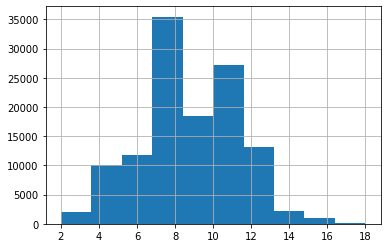

In [24]:
X_train["title"].apply(lambda x:len(x)).hist()

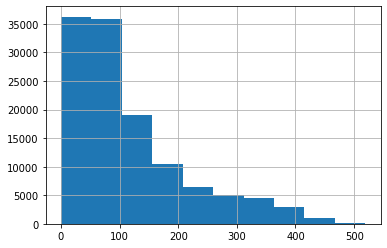

In [25]:
X_train["description"].apply(lambda x:len(x)).hist()

In [26]:
y_train.head()

159103     6640.0
3652       9000.0
117594    11400.0
123810    18900.0
136572     3540.0
Name: price, dtype: float64

In [27]:
y_train = np.log1p(y_train)
y_valid = np.log1p(y_valid)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid = y_scaler.transform(y_valid.values.reshape(-1, 1))

In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_train["status"] = le.fit_transform(X_train["status"])
X_valid["status"] = le.transform(X_valid["status"])

In [29]:
MAX_TITLE_SEQ = np.max(X_train["title"].apply(lambda x:len(x)))
MAX_DESC_SEQ  = np.max(X_train["description"].apply(lambda x:len(x)))
MAX_TEXT = np.max([np.max(X_train.title.max())
                   , np.max(X_valid.title.max())
                   , np.max(X_train.description.max())
                   , np.max(X_valid.description.max())])+2

In [30]:
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(df):
  X = {
       "title"  : pad_sequences(df["title"], maxlen=MAX_TITLE_SEQ),
       "status": np.array(df["status"]),
       "shipping": np.array(df["shipping"]),
       "description": pad_sequences(df["description"], maxlen=MAX_DESC_SEQ),
  }
  return X

X_train = get_keras_data(X_train)
X_valid = get_keras_data(X_valid)

In [31]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.layers import Input, Dropout, Dense, BatchNormalization,LSTM, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization, Bidirectional
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam

def get_callbacks(filepath, patience=10):
  es = EarlyStopping("val_loss", patience=patience, mode="min")
  msave = ModelCheckpoint(filepath, save_best_only=True)
  return [es, msave]

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def mean_absolute_percentage_error(y_true, y_pred): 
    return K.mean(K.abs((y_true - y_pred) / y_true)) * 100

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))


def get_model():
  #params
    dr_r = 0.4
    
    #Inputs
    title       = Input(shape=[X_train["title"].shape[1]], name="title")
    description = Input(shape=[X_train["description"].shape[1]], name="description")
    status      = Input(shape=[1], name="status")
    shipping    = Input(shape=[1], name="shipping")
    
    #Embeddings layers
    emb_title     = Embedding(160854,  256)(title)
    emb_item_desc = Embedding(160854, 512)(description)
    
    #rnn layer
    rnn_layer1 = Bidirectional(LSTM(32)) (emb_title)
    rnn_layer2 = Bidirectional(LSTM(64)) (emb_item_desc)
    
    #main layer
    main_l = concatenate([
          rnn_layer1
        , rnn_layer2
        , status
        , shipping
    ])
    dence1 = Dense(128)(main_l)
    activation1 = Activation("relu")(dence1)
    batch1      = BatchNormalization()(activation1)
    drop1  = Dropout(dr_r) (batch1)

    dence2 = Dense(64)(drop1)
    activation2 = Activation("relu")(dence2)
    batch2      = BatchNormalization()(activation2)
    drop2  = Dropout(dr_r) (batch2)
    
    #output
    output = Dense(1, activation="linear") (drop2)
    
    #model
    model = Model([title, description, status, shipping], output)

    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, decay=0.)
    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model


In [32]:
#FITTING THE MODEL
BATCH_SIZE = 128
epochs = 200

model = get_model()
model.summary()
model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, y_valid)
          , callbacks=[get_callbacks("./")]
          , verbose=1)

pred = model.predict(X_valid)
pred = y_scaler.inverse_transform(pred)
pred = np.expm1(pred)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 18)]         0                                            
__________________________________________________________________________________________________
description (InputLayer)        [(None, 519)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 256)      41178624    title[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 519, 512)     82357248    description[0][0]                
_______________________________________________________________________________________

KeyboardInterrupt: ignored

In [278]:
from sklearn.metrics import mean_absolute_error, r2_score

y_valid_n = np.expm1(y_scaler.inverse_transform(y_valid))

mae   =  mean_absolute_error(y_valid_n, pred)
#rmsle =  np.sqrt(mean_squared_log_error(y_valid, pred))
mse   =  mean_squared_error(y_valid_n, pred)
rmse  =  np.sqrt(mean_squared_error(y_valid_n, pred))
mape  =  mean_absolute_percentage_error(y_valid_n, pred)
r2    =  r2_score(y_valid_n, pred)

print("mae:", mae)
print("mse:", mse)
print("rmse:",rmse)
#print("rmsle:", rmsle)
print("mape:",mape)
print("r2:", r2)

mae: 2759.7773017372615
mse: 24270757.698115487
rmse: 4926.536074983668
mape: tf.Tensor(35.3456353725514, shape=(), dtype=float64)
r2: 0.55554197269801


AttributeError: ignored